In [1]:
!pip install opendatasets

In [2]:
!git clone https://github.com/MorningStarTM/unsupervised-pre-training-vgg.git

Cloning into 'unsupervised-pre-training-vgg'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 120 (delta 57), reused 104 (delta 46), pack-reused 0
Receiving objects: 100% (120/120), 18.02 KiB | 4.50 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [5]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/obulisainaren/multi-cancer")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ernestbeckham
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/obulisainaren/multi-cancer


100%|██████████| 8.62G/8.62G [01:47<00:00, 86.2MB/s]


In [ ]:
import os
os.chdir('../')
os.getcwd()

'e:\\github_clone\\unsupervised-pre-training-vgg'

In [2]:
%cd unsupervised-pre-training-vgg

/content/unsupervised-pre-training-vgg


In [3]:
!ls

brain_tumor_2.csv  multi-cancer  README.md	 torch_modules
LICENSE		   notebooks	 tensorflow_src  vgg_for_brain_cancer.keras


In [4]:
from tensorflow_src import vgg_encoder
import numpy as np
import cv2
import os
from glob import glob
from tqdm import tqdm
import itertools
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.callbacks import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow_src.pipeline import load_data, PlotImg, tf_dataset, process_image
from tensorflow_src.evaluation import batch_prediction
from tensorflow_src.const import *

In [5]:
model_path = "vgg_for_brain_cancer.keras"
csv_path = "brain_tumor_2.csv"

In [6]:
path = "/content/unsupervised-pre-training-vgg/multi-cancer/Multi Cancer/Brain Cancer"
train, valid, test = load_data(path)

In [7]:
print(f"Train:{len(train)} - Valid: {len(valid)} - Test:{len(test)}")

Train:9000 - Valid: 3000 - Test:3000


In [8]:
  #tensor dataset
train_df = tf_dataset(train)
valid_df = tf_dataset(valid)
test_df = tf_dataset(test)

In [9]:
for i,j in test_df.take(1):
    print(i.numpy().shape)

(32, 256, 256, 3)


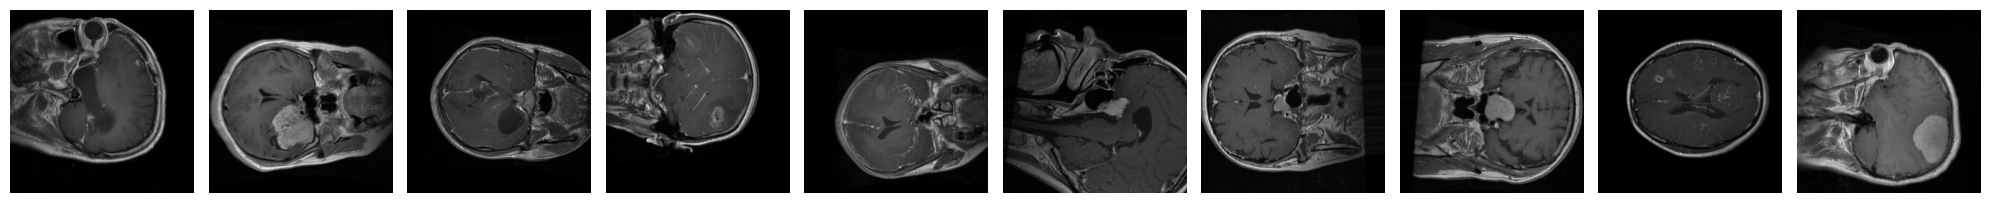

In [10]:
imgs, labels = next(iter(train_df))
PlotImg(imgs)

# Model

In [11]:
vgg = vgg_encoder((256,256,3))
x = vgg.output
flatten = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(128, activation='relu')(flatten)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)

outputs = tf.keras.layers.Dense(num_class, activation='softmax')(dense)
vgg = tf.keras.Model(vgg.input, outputs)

In [12]:
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      1744      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      9232      
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 16)      9232      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      18464     
                                                             

In [13]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=6, min_lr=2e-9, verbose=1),
    EarlyStopping(monitor='val_loss', patience=9, verbose=1, restore_best_weights=True)
]

In [14]:
vgg.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
r = vgg.fit(x=train_df, validation_data=valid_df, epochs=30, callbacks=callbacks)

Epoch 1/30
282/282 [==============================] - ETA: 0s - loss: 0.8382 - accuracy: 0.5970
Epoch 1: val_loss improved from inf to 0.74996, saving model to vgg_for_brain_cancer.keras
282/282 [==============================] - 135s 409ms/step - loss: 0.8382 - accuracy: 0.5970 - val_loss: 0.7500 - val_accuracy: 0.6727 - lr: 3.0000e-04
Epoch 2/30
282/282 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.8028
Epoch 2: val_loss improved from 0.74996 to 0.37359, saving model to vgg_for_brain_cancer.keras
282/282 [==============================] - 108s 384ms/step - loss: 0.5051 - accuracy: 0.8028 - val_loss: 0.3736 - val_accuracy: 0.8593 - lr: 3.0000e-04
Epoch 3/30
282/282 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8551
Epoch 3: val_loss improved from 0.37359 to 0.31667, saving model to vgg_for_brain_cancer.keras
282/282 [==============================] - 108s 382ms/step - loss: 0.3813 - accuracy: 0.8551 - val_loss: 0.3167 - val_accuracy:

# Evaluation

confusion matrix without normalization
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       979
           1       0.98      0.99      0.98       998
           2       0.98      0.95      0.96      1023

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



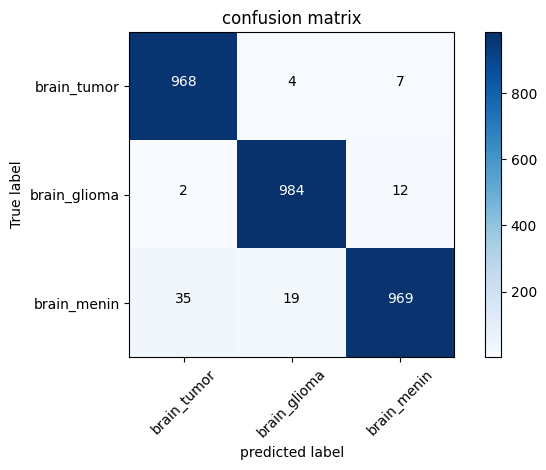

In [16]:
batch_prediction(model_path, test_df, test)

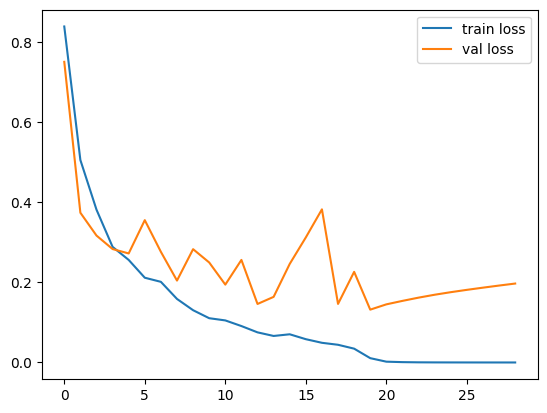

<function matplotlib.pyplot.show(close=None, block=None)>

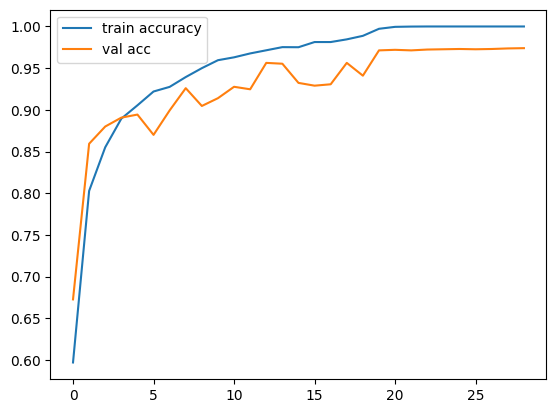

In [17]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show